# Logistic Regression on Canada Per Capita Income (from scratch)

Uses only NumPy for math and Matplotlib for visualization; implements binary logistic regression with gradient descent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load the CSV dataset
Dataset: `canada_per_capita_income.csv` (year, income). We create a binary label: income above the median = 1, else 0.

In [2]:
def load_dataset(csv_path):
    """Load year/income CSV with NumPy only."""
    data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
    x = data[:, 0:1]  # year
    y_cont = data[:, 1:1+1]  # income
    return x, y_cont

# Load data
csv_path = "canada_per_capita_income.csv"
x_raw, y_cont = load_dataset(csv_path)
print(f"Loaded {x_raw.shape[0]} rows from {csv_path}")

Loaded 47 rows from canada_per_capita_income.csv


## 2. Prepare data and labels
We binarize income around the median: label 1 if income ≥ median, else 0. Split train/test (80/20).

In [3]:
def train_test_split(x, y, test_ratio=0.2):
    """Manual shuffle split."""
    m = x.shape[0]
    idx = np.random.permutation(m)
    test_size = int(m * test_ratio)
    test_idx = idx[:test_size]
    train_idx = idx[test_size:]
    return x[train_idx], x[test_idx], y[train_idx], y[test_idx]

# Create binary labels and split
median_income = np.median(y_cont)
y = (y_cont >= median_income).astype(int)

x_train, x_test, y_train, y_test = train_test_split(x_raw, y, test_ratio=0.2)
print(f"Train size: {x_train.shape[0]}, Test size: {x_test.shape[0]}")

Train size: 38, Test size: 9


## 3. Model equations (univariate logistic regression)
- Sigmoid: $\sigma(z) = \dfrac{1}{1 + e^{-z}}$
- Hypothesis: $\hat{y} = \sigma(w_0 + w_1 x)$
- Cost (binary cross-entropy): $J(w) = -\dfrac{1}{m}\sum_{i=1}^m\big[y^{(i)}\log \hat{y}^{(i)} + (1-y^{(i)})\log(1-\hat{y}^{(i)})\big]$
- Gradients:
  - $\dfrac{\partial J}{\partial w_0} = \dfrac{1}{m}\sum (\hat{y} - y)$
  - $\dfrac{\partial J}{\partial w_1} = \dfrac{1}{m}\sum (\hat{y} - y)x$
- Updates (gradient descent): $w \leftarrow w - \alpha \nabla J$

In [4]:
def normalize_feature(x):
    mean = np.mean(x)
    std = np.std(x) + 1e-8
    return (x - mean) / std, mean, std


def add_bias(x):
    return np.hstack([np.ones((x.shape[0], 1)), x])


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))


def predict_proba(X, w):
    return sigmoid(X @ w)


def compute_cost(X, y, w):
    m = X.shape[0]
    p = predict_proba(X, w)
    eps = 1e-15
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))


def compute_gradient(X, y, w):
    m = X.shape[0]
    p = predict_proba(X, w)
    return (1.0 / m) * (X.T @ (p - y))


def gradient_descent(X, y, alpha=0.1, num_iters=2000, verbose=False):
    w = np.zeros((X.shape[1], 1))
    costs = []
    for i in range(num_iters):
        grad = compute_gradient(X, y, w)
        w -= alpha * grad
        if verbose and i % 200 == 0:
            cost = compute_cost(X, y, w)
            costs.append(cost)
            print(f"Iter {i:4d} | Cost {cost:.6f}")
        elif not verbose:
            costs.append(compute_cost(X, y, w))
    return w, costs


def predict(X, w, threshold=0.5):
    return (predict_proba(X, w) >= threshold).astype(int)


def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

## 4. Train the model

In [5]:
# Normalize feature, build design matrix, and run gradient descent
x_train_norm, x_mean, x_std = normalize_feature(x_train)
x_test_norm = (x_test - x_mean) / x_std

X_train = add_bias(x_train_norm)
X_test = add_bias(x_test_norm)

alpha = 0.3
num_iters = 1500

w, costs = gradient_descent(X_train, y_train, alpha=alpha, num_iters=num_iters, verbose=True)

print("Training complete.")
print(f"Final cost: {costs[-1]:.6f}")

Iter    0 | Cost 0.641124
Iter  200 | Cost 0.165873
Iter  400 | Cost 0.156221
Iter  600 | Cost 0.153657
Iter  800 | Cost 0.152711
Iter 1000 | Cost 0.152308
Iter 1200 | Cost 0.152123
Iter 1400 | Cost 0.152033
Training complete.
Final cost: 0.152033


## 5. Evaluate and visualize

Train accuracy: 92.11%
Test accuracy:  77.78%


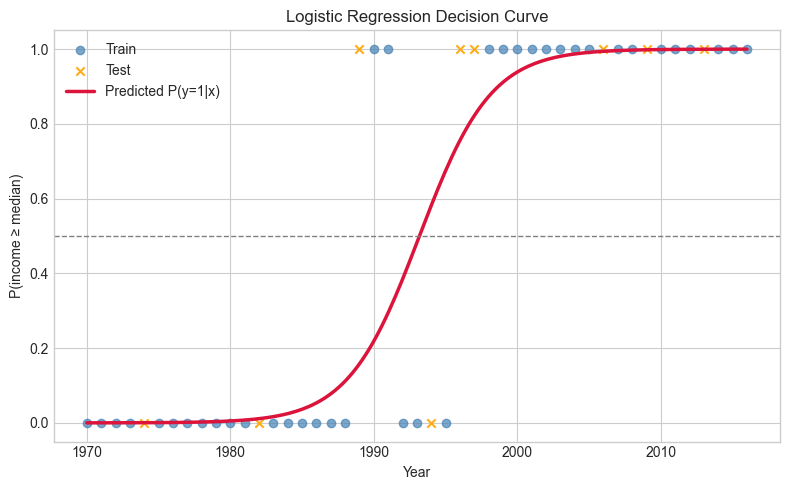

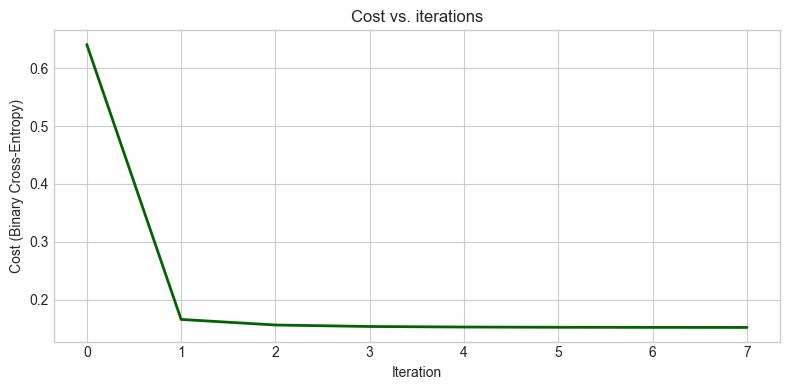

In [6]:
# Predictions and accuracy
y_train_pred = predict(X_train, w)
y_test_pred = predict(X_test, w)

train_acc = accuracy(y_train, y_train_pred)
test_acc = accuracy(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.2f}%")
print(f"Test accuracy:  {test_acc:.2f}%")

# Plot data and decision boundary
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, label="Train", color="steelblue", alpha=0.7)
plt.scatter(x_test, y_test, label="Test", color="orange", alpha=0.9, marker="x")

x_line = np.linspace(x_raw.min(), x_raw.max(), 200).reshape(-1, 1)
x_line_norm = (x_line - x_mean) / x_std
X_line = add_bias(x_line_norm)
probs = predict_proba(X_line, w)

plt.plot(x_line, probs, color="crimson", linewidth=2.5, label="Predicted P(y=1|x)")
plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("P(income ≥ median)")
plt.title("Logistic Regression Decision Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Plot cost curve
plt.figure(figsize=(8, 4))
plt.plot(costs, color="darkgreen", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Cost (Binary Cross-Entropy)")
plt.title("Cost vs. iterations")
plt.tight_layout()
plt.show()